In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp12.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_price,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,6.318052,235.343453,108.926934,0.349570,0.491404,0.012178,0.018625,0.017192,0.018625,0.006447,...,0.010029,0.005014,0.007880,0.063037,0.018625,0.018625,0.006447,0.007880,0.009312,0.012178
std,3.471418,212.669079,235.188518,0.477005,0.500105,0.109718,0.135244,0.130033,0.135244,0.080063,...,0.099675,0.070659,0.088449,0.243117,0.135244,0.135244,0.080063,0.088449,0.096084,0.109718
min,1.000000,6.910000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,114.035417,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,175.671332,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,286.890767,90.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1903.950000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_price,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,205.618941,664,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,245.817299,225,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,216.730145,211,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,206.905313,634,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,199.342329,1343,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'unit_price',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,unit_price,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,205.618941,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,245.817299,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,216.730145,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,206.905313,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,199.342329,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

# mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
# regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5



In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    196.839647  21.845770  0.691555  0.024238  1.924762  0.366036   
gbm     147.354940  24.849989  0.951160  0.030941  4.115200  0.962241   
gbm_q   195.514146  32.722887  0.732197  0.034097  2.210362  0.427109   

                 MSE                      MAE                   R2            
                mean           std       mean        std      mean       std  
r_name                                                                        
gb_q    39143.544711   7923.070143  82.468037  13.083297  0.281421  0.046123  
gbm     22228.080019   6809.494623  86.734064  13.527417  0.598224  0.075527  
gbm_q   39118.104254  11656.877305  85.409463  12.347179  0.293872  0.120607

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 139.4519
MAPE': 2.6806
MDAPE': 0.7931
MSE: 19446.8240
MAE: 66.2480
R2: 0.6540


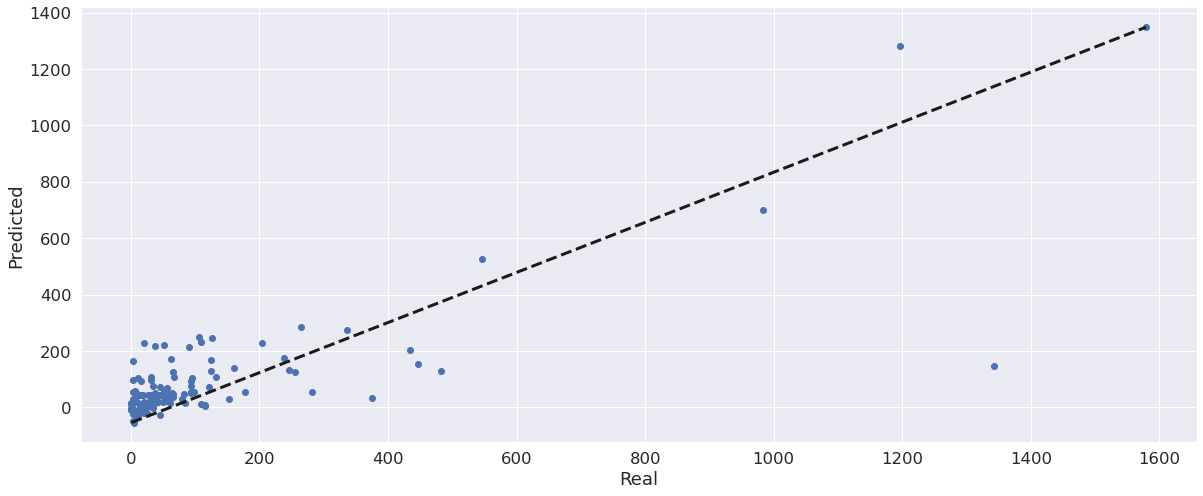

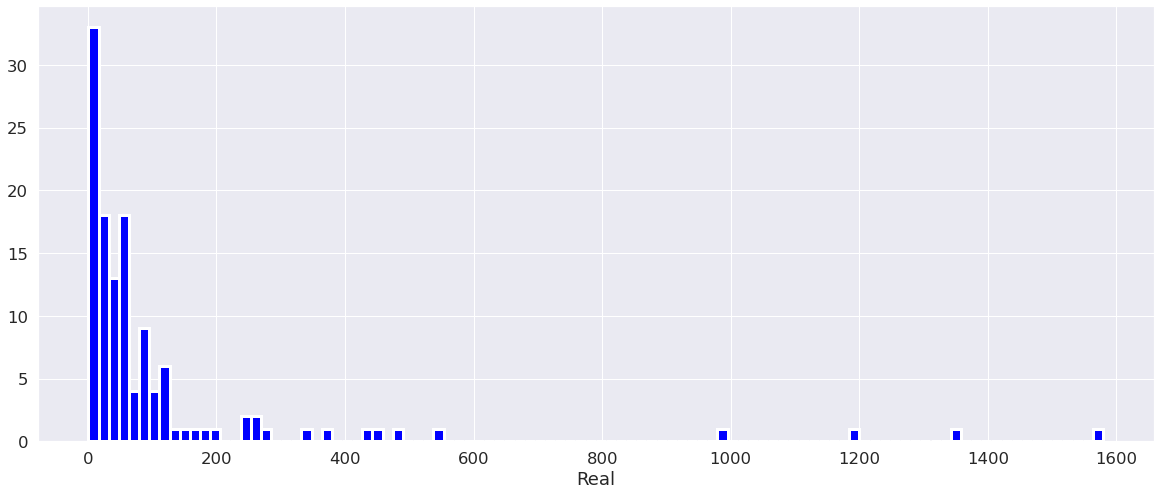

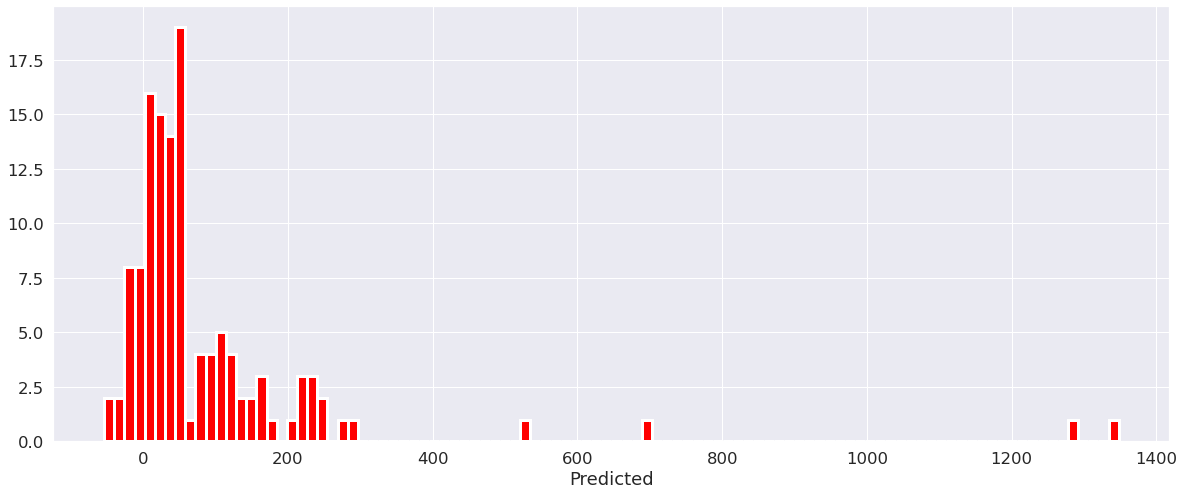


Validating gbm on set 6 and 2017-04
932 122
RMSE : 119.2352
MAPE': 3.3729
MDAPE': 0.6727
MSE: 14217.0328
MAE: 64.7213
R2: 0.7093


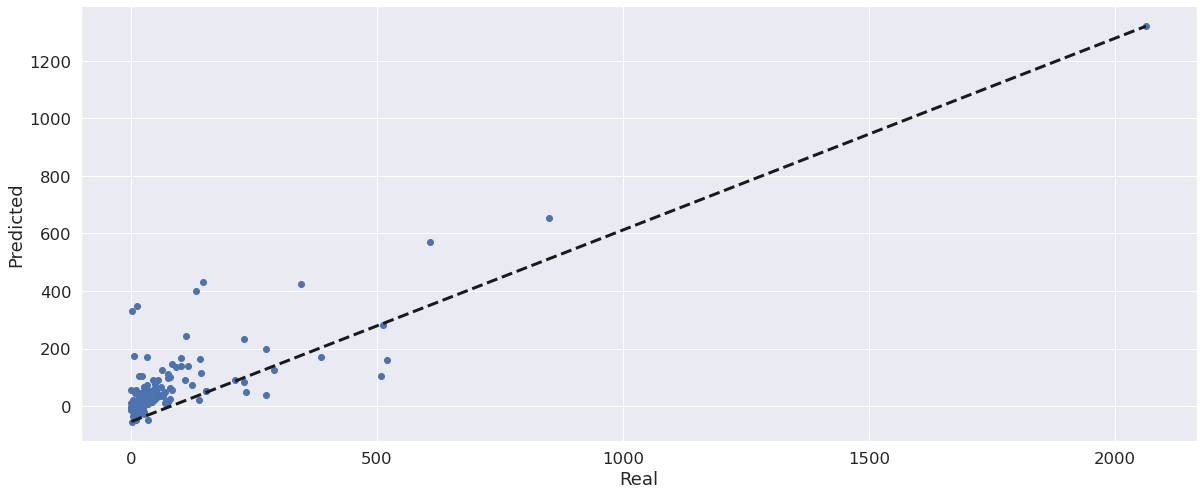

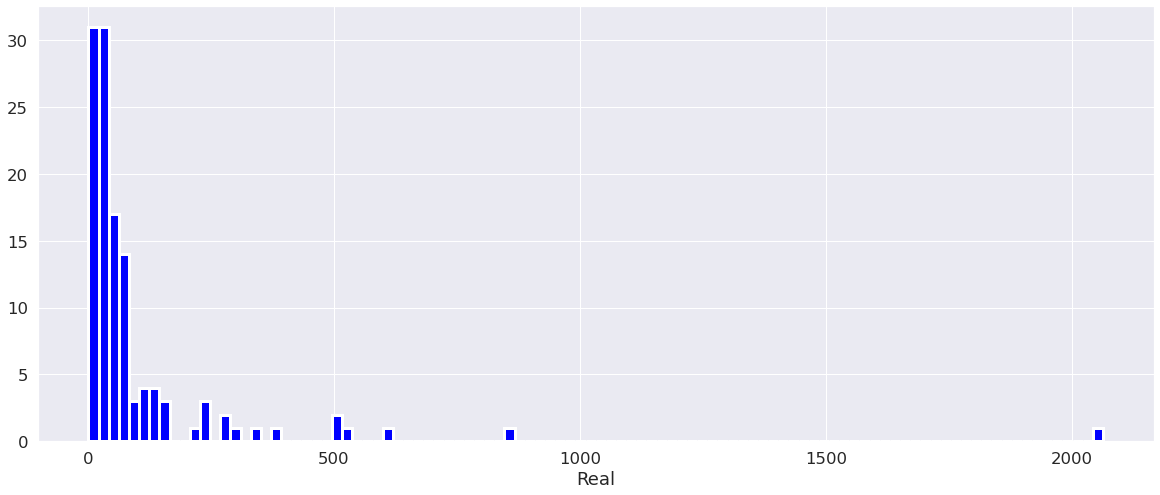

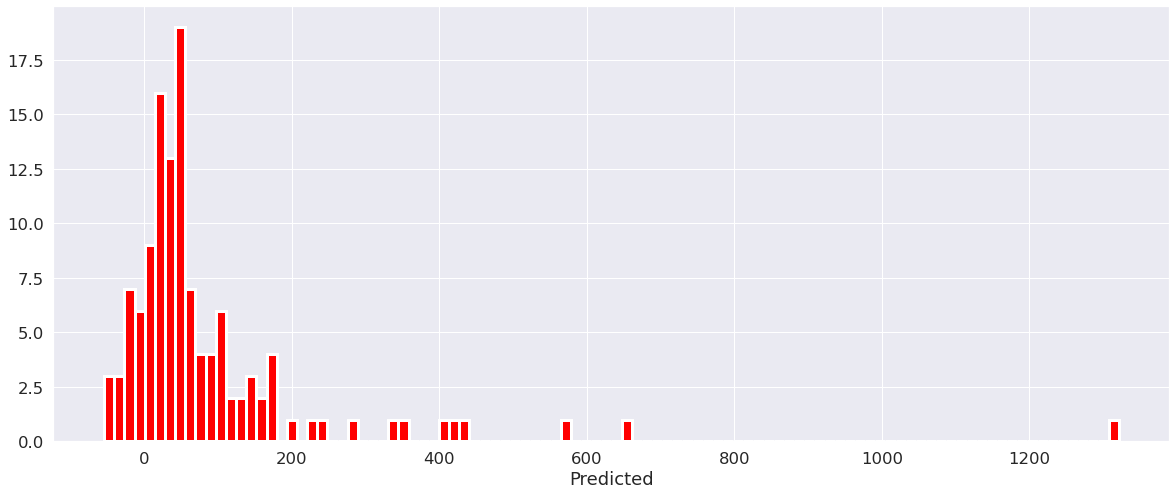


Validating gbm on set 6 and 2017-05
932 121
RMSE : 171.9686
MAPE': 2.0110
MDAPE': 0.7120
MSE: 29573.1901
MAE: 92.2149
R2: 0.6033


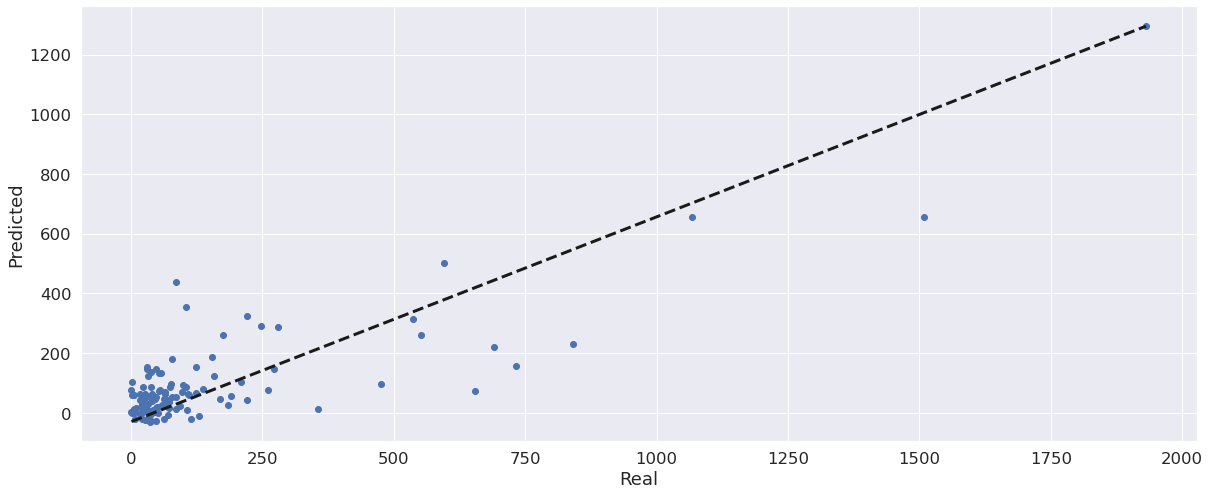

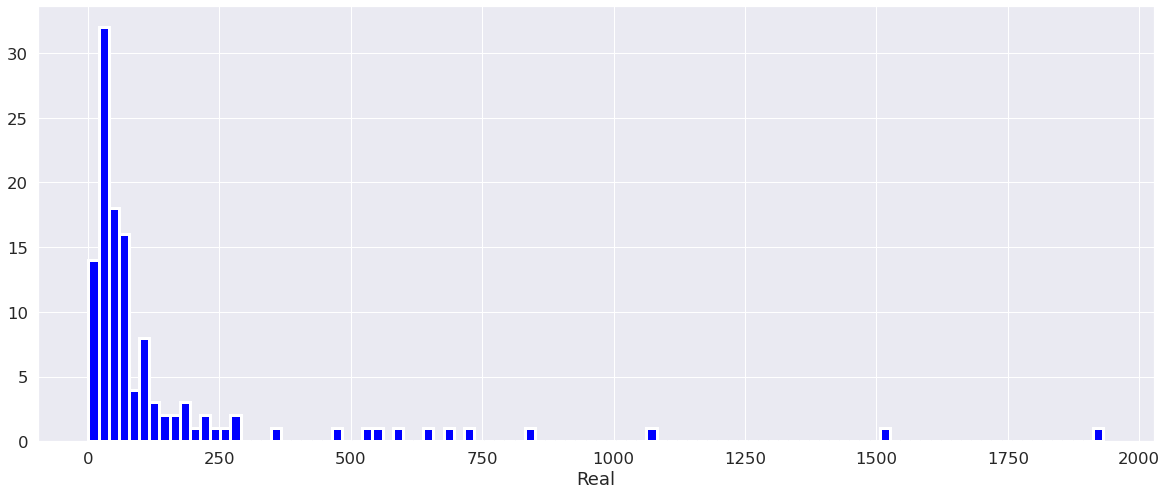

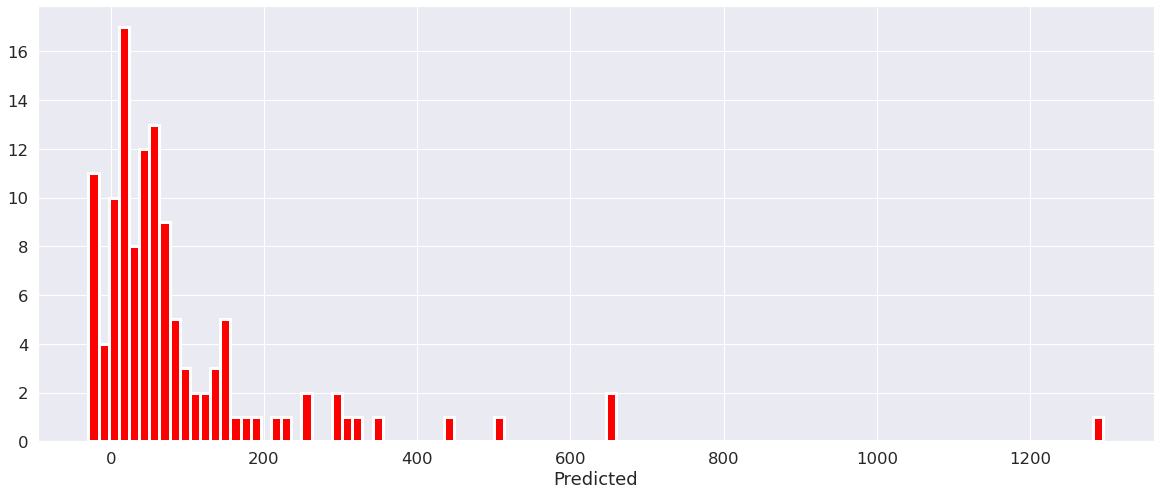


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 165.8141
MAPE': 1.8989
MDAPE': 0.4737
MSE: 27494.3200
MAE: 67.2960
R2: 0.5109


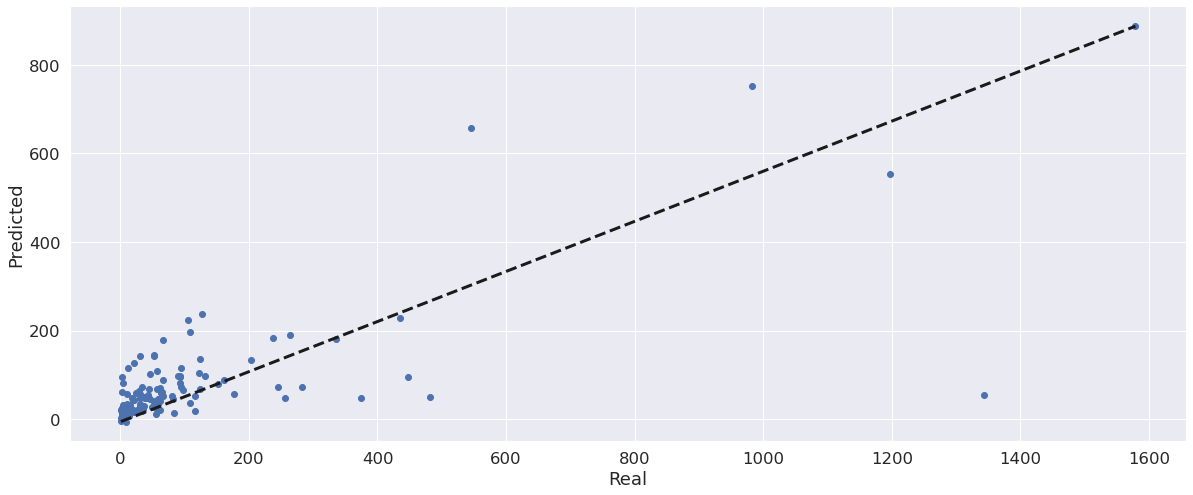

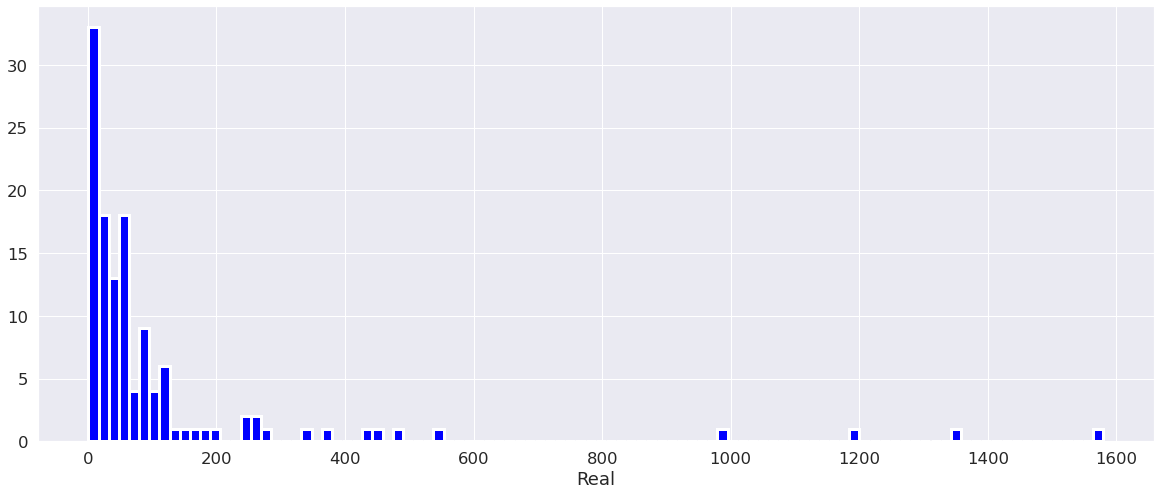

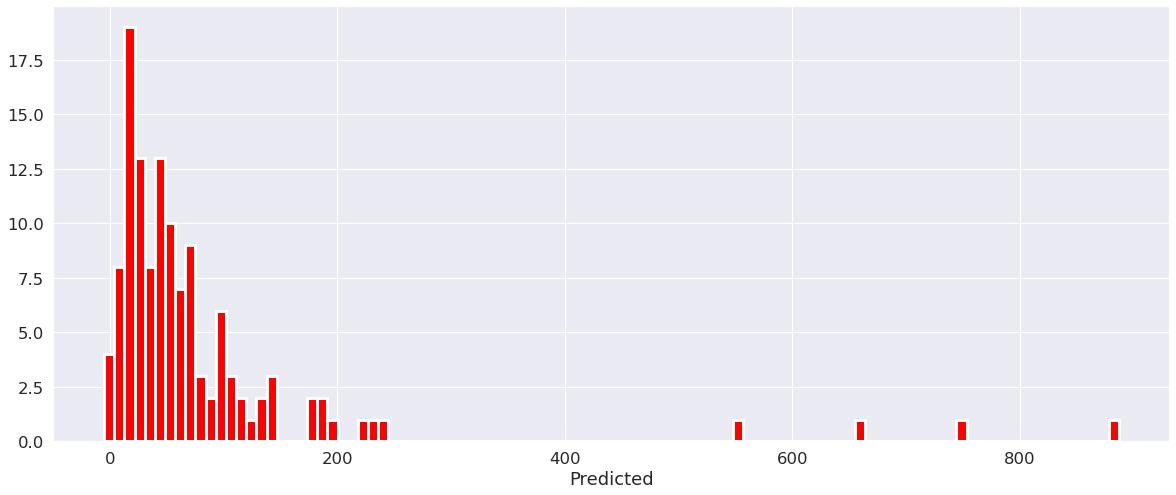


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 159.2115
MAPE': 2.1302
MDAPE': 0.6217
MSE: 25348.2869
MAE: 69.6967
R2: 0.4817


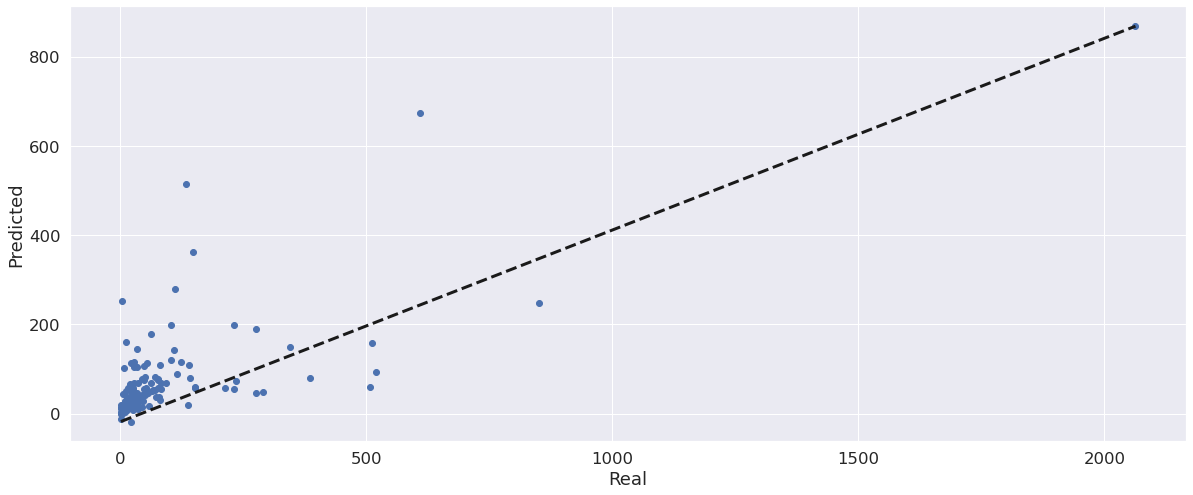

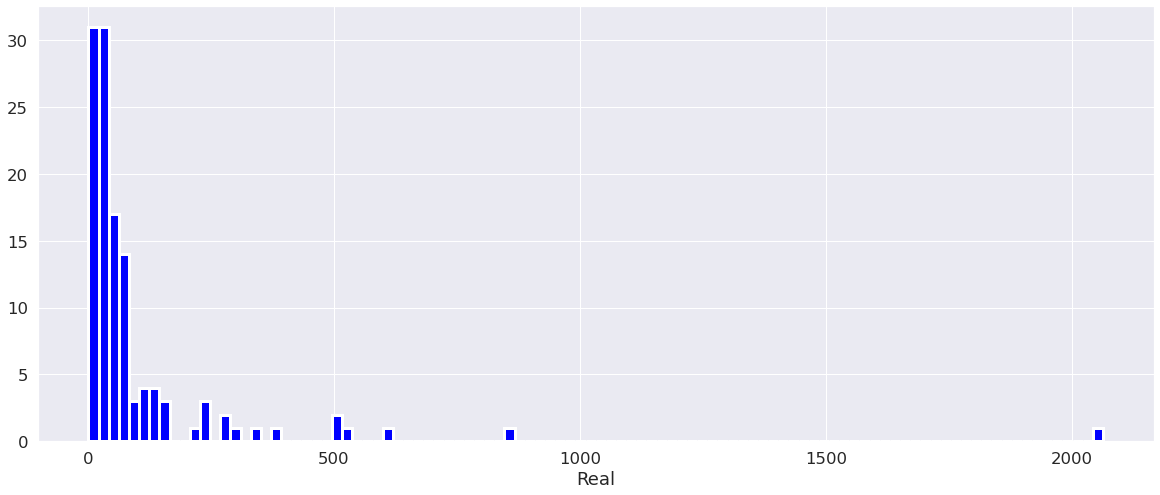

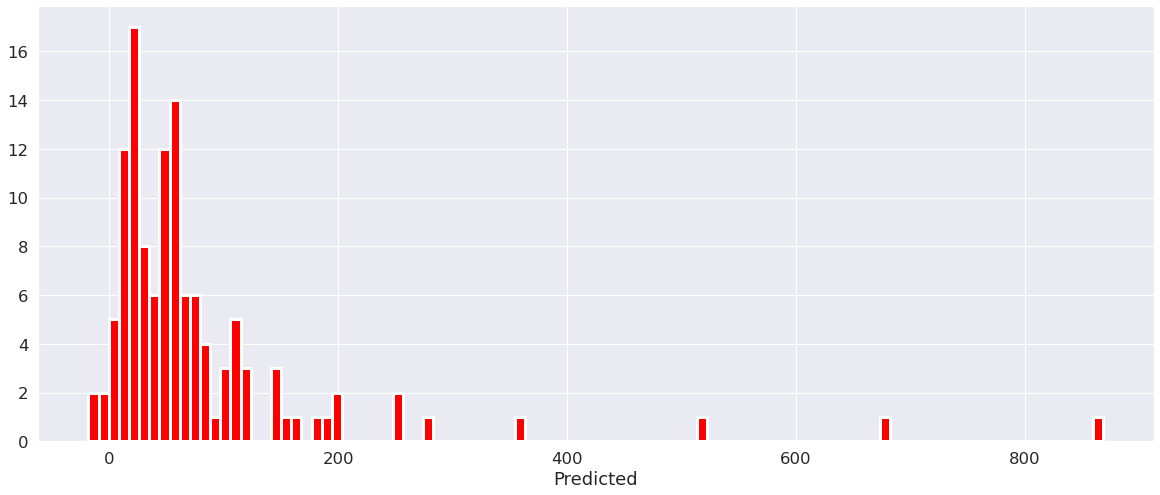


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 213.0882
MAPE': 0.8408
MDAPE': 0.6438
MSE: 45406.5702
MAE: 95.7603
R2: 0.3910


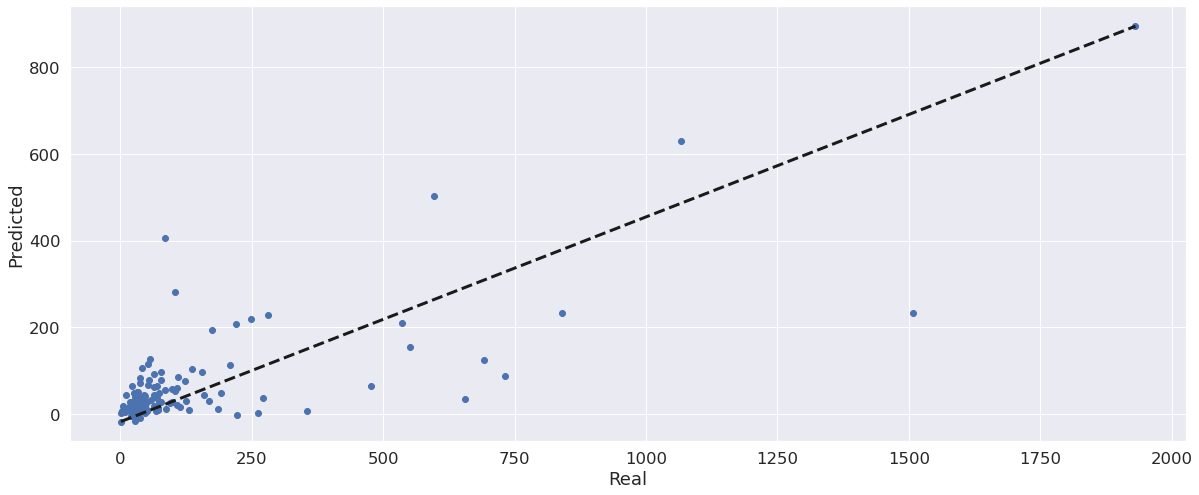

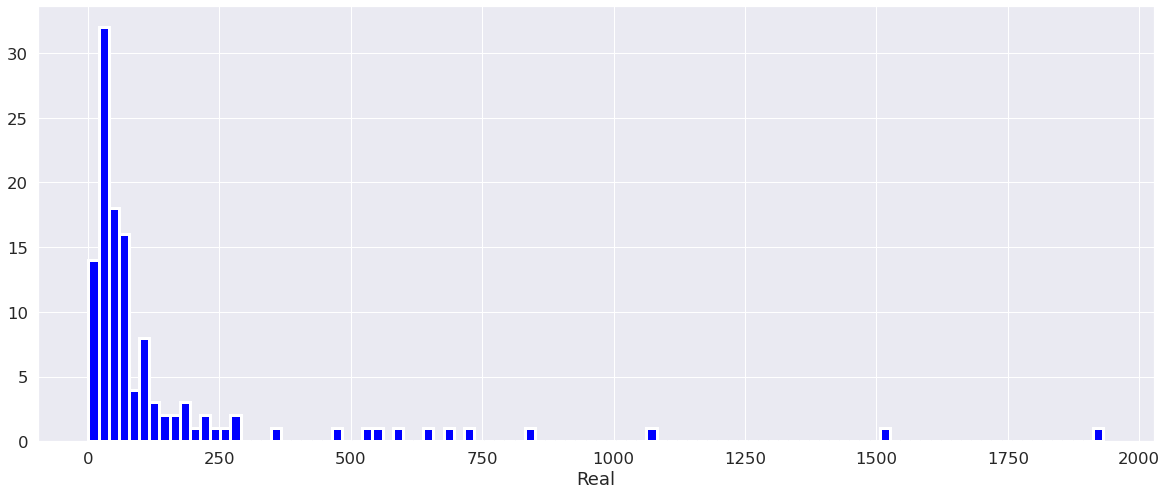

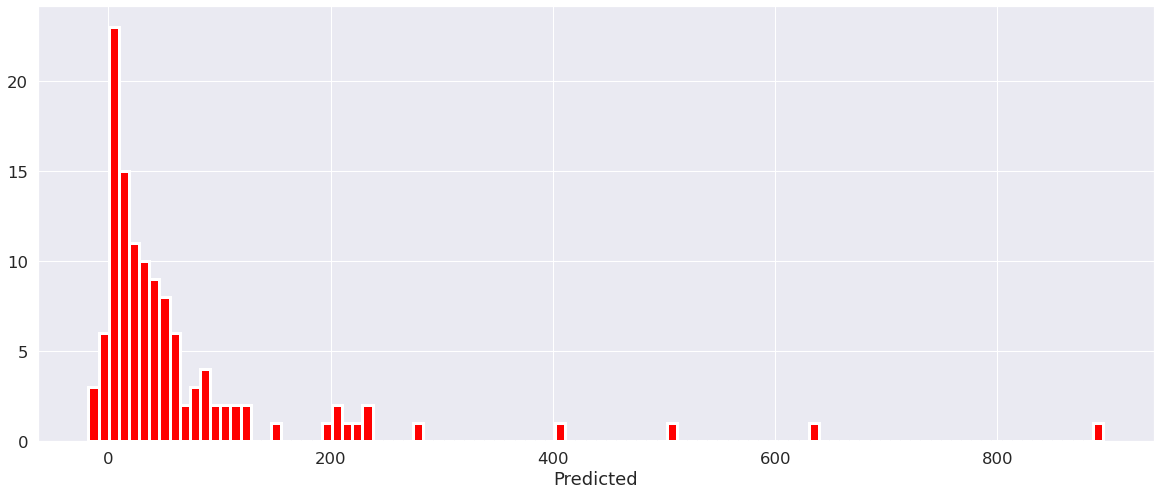


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 209.8042
MAPE': 2.2455
MDAPE': 0.6429
MSE: 44017.7920
MAE: 82.5920
R2: 0.2169


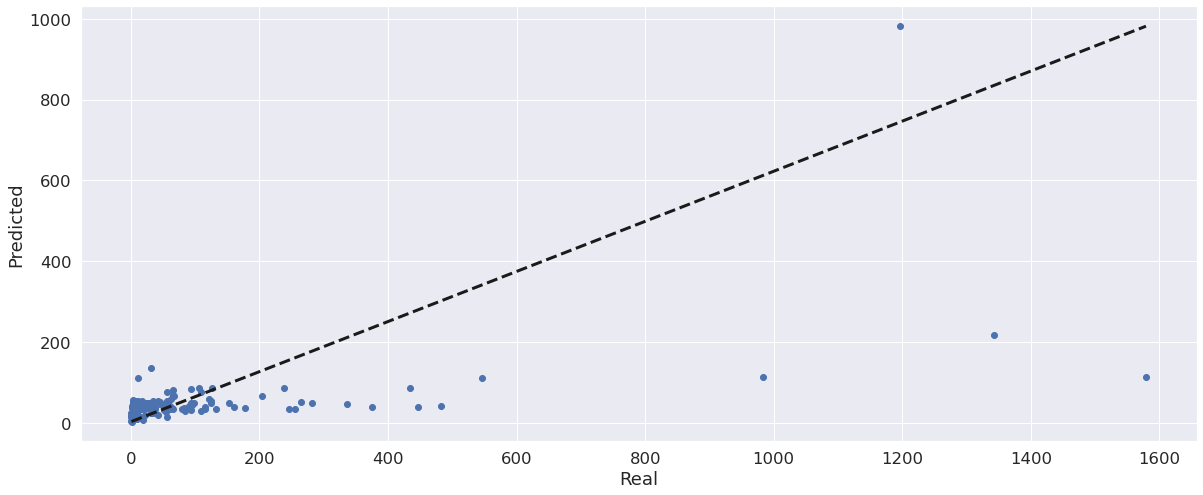

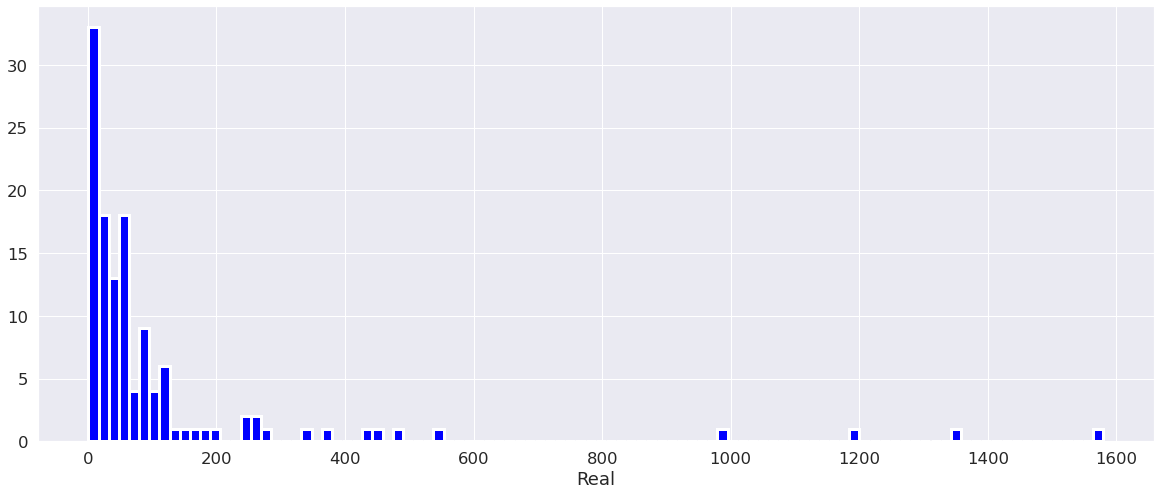

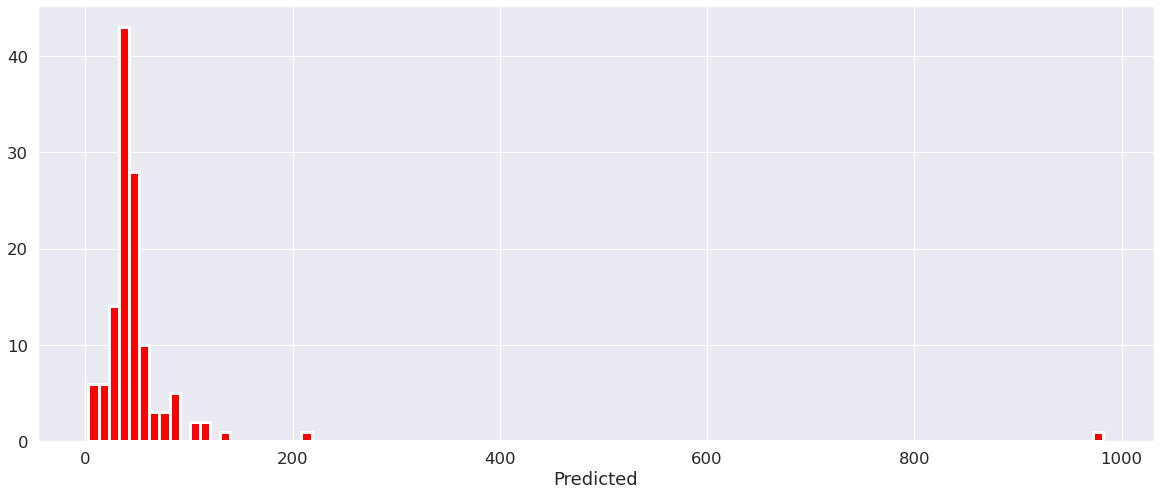


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 206.5288
MAPE': 1.5572
MDAPE': 0.5904
MSE: 42654.1393
MAE: 69.9262
R2: 0.1279


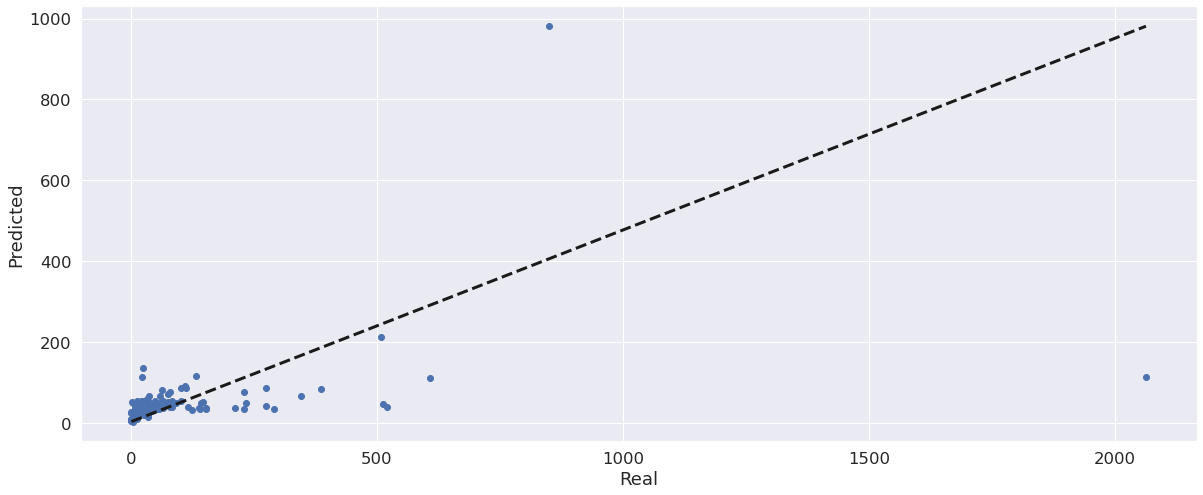

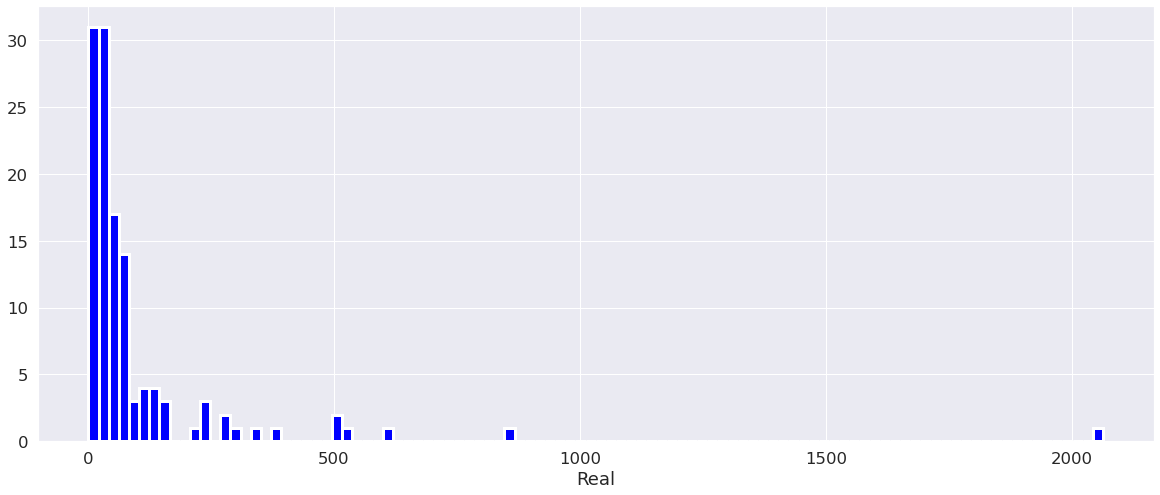

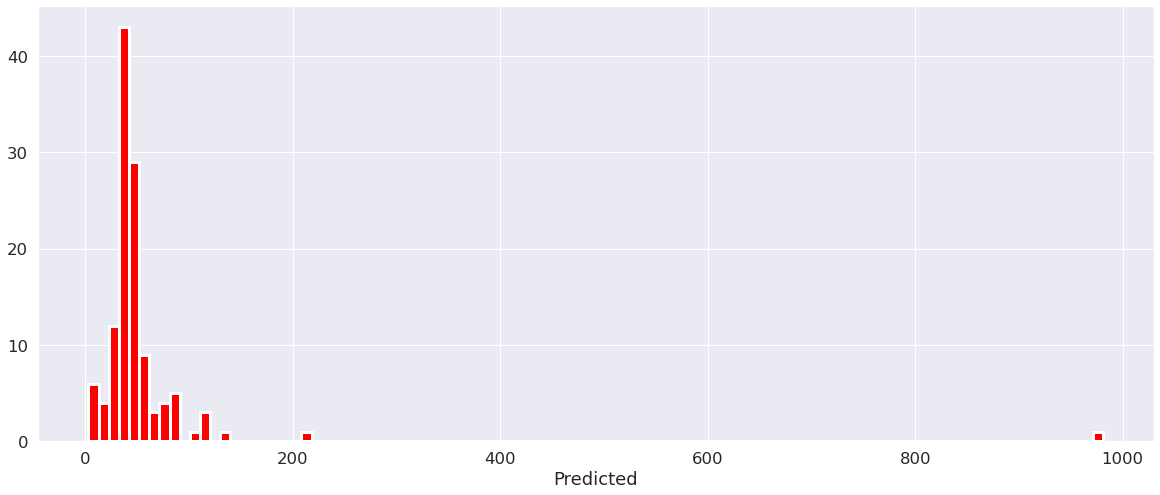


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 249.8013
MAPE': 0.8273
MDAPE': 0.5314
MSE: 62400.6694
MAE: 104.5207
R2: 0.1630


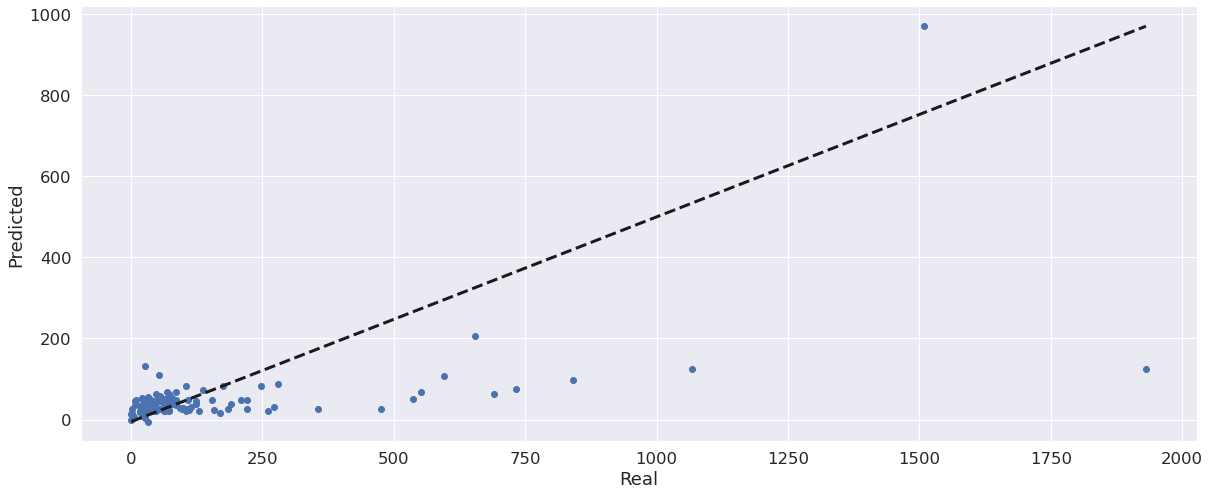

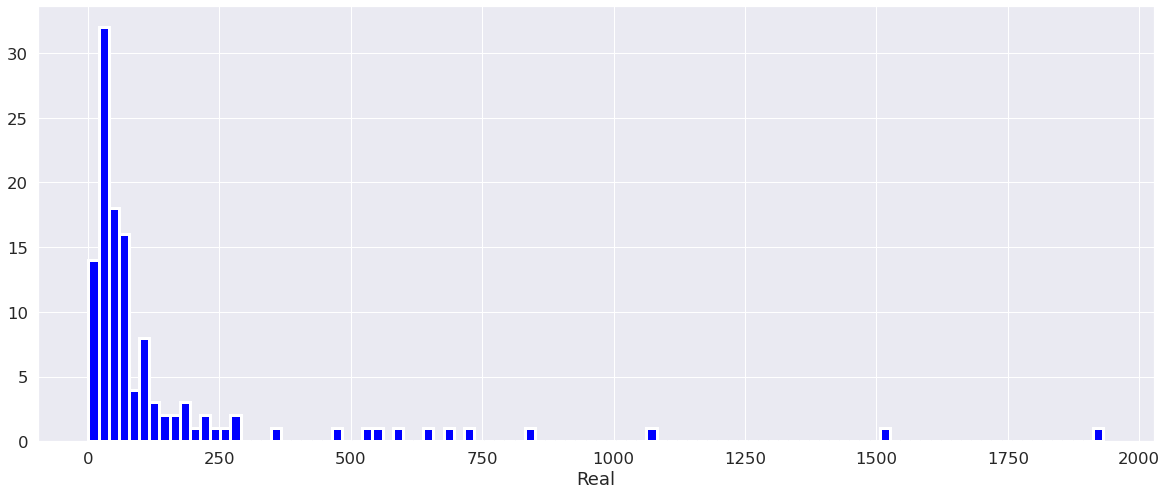

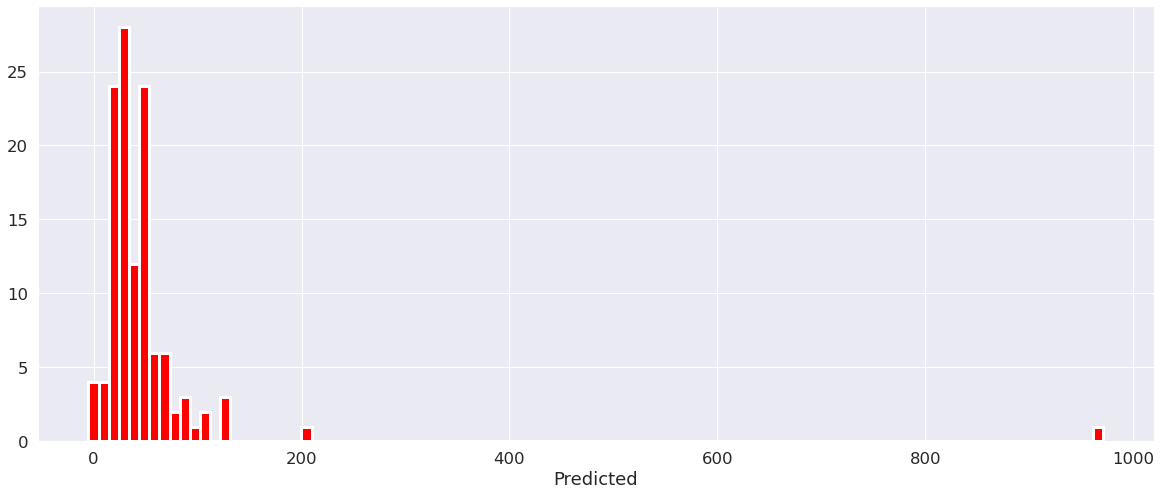

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,139.451870,2.680625,0.793103,19446.824000,66.248000,0.654030,LGBMRegressor(random_state=42),gbm,6,2017-03
3,165.814113,1.898943,0.473684,27494.320000,67.296000,0.510861,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,209.804175,2.245546,0.642857,44017.792000,82.592000,0.216899,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
1,119.235199,3.372888,0.672652,14217.032787,64.721311,0.709319,LGBMRegressor(random_state=42),gbm,6,2017-04
4,159.211453,2.130198,0.621711,25348.286885,69.696721,0.481729,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,206.528786,1.557156,0.590354,42654.139344,69.926230,0.127894,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
2,171.968573,2.010954,0.712042,29573.190083,92.214876,0.603347,LGBMRegressor(random_state=42),gbm,6,2017-05
5,213.088175,0.840797,0.643836,45406.570248,95.760331,0.390980,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
8,249.801260,0.827346,0.531429,62400.669421,104.520661,0.163045,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-05
